# CS224 - Spring 2025 - HW1 - Joy-o-Meter

Submit **PDF** of completed IPython notebook on Canvas

**Due**: February 2, 2025 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Aryan Ramachandra
  </br>
  <b>Student ID Number</b>:  862545919
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment you will implement a simple linear neural network that reads in text and uses pretrained embeddings to predict the **happiness intensity** of the text.
You'll fit the network weights using the analytic expression we discussed in class.

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, "pandas" for data loading, matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the code marked `TODO` and print desired results.

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## **Getting and processing data [2 points]**
You can download the two data files here:

https://elearn.ucr.edu/files/17302828/download?download_frd=1

https://elearn.ucr.edu/files/17302824/download?download_frd=1

You'll have to make them available locally or upload them to your colab instance.

In [ ]:
# Load dataset and visualize
train_file = 'EI-reg-En-joy-train.txt'
val_file = '2018-EI-reg-En-joy-dev.txt'
df_train = pd.read_csv(train_file, sep='\t')
df_val = pd.read_csv(val_file, sep='\t')

tweets_train = df_train['Tweet'].tolist()  # Create a list of tweets
tweets_val = df_val['Tweet'].tolist()

# Create a list of intensity scores
y_train = torch.tensor(df_train['Intensity Score'], dtype=torch.float32)  # match to dtype of embedding
y_val = torch.tensor(df_val['Intensity Score'], dtype=torch.float32)

print('Score - Tweet')
for i in range(5):
    print('{:0.2f} - {}'.format(y_train[i], tweets_train[i]))

Score - Tweet
0.14 - @david_garrett Quite saddened.....no US dates, no joyous anticipation of attending a DG concert (since 2014). Happy you are keeping busy.
0.79 - 2 days until #GoPackGo and 23 days until #GoGipeGo..... I'm so excited! 
0.27 - Positive #psychology research shows salespeople who score in the top 10% for #optimism have 88% &gt; sales than those in top 10% for pessimism.
0.48 - As the birds chirp and the cows moo we need to listen to the sound of nature to ensure that all is well.
0.94 - Howling with laughter at “WELL DONE BEZZA!” #bakeoff #GBBO


In [ ]:
# TODO [1 point]: load a pretrained model and write a function that embeds sentences into vector space
# Use the approach shown in Jan. 17 class (or improve on it)

model_name="bert-base-uncased"  # Many possibilities on huggingface.com

# Load the model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def embed_sentence(model, tokenizer, sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embedding = outputs.last_hidden_state[:, 0, :]

    return sentence_embedding


In [ ]:
# TODO [1 point]: Use embed_sentence to turn text into a matrix of embeddings.
# Create a pytorch matrix where each row corresponds to a tweet,
# and the number of columns/features is the size of the embedding
# (Obviously one for train and one for validation)
# For me, on the CPU of my laptop, it took about a minute or two to do the processing

X_train = torch.zeros((len(tweets_train), 768))  # Placeholder tensor for training embeddings
X_val = torch.zeros((len(tweets_val), 768))  # Placeholder tensor for validation embeddings

# Embed training tweets
with torch.no_grad():
    for i, tweet in enumerate(tweets_train):
        X_train[i] = embed_sentence(model, tokenizer, tweet).squeeze(0)

# Embed validation tweets
with torch.no_grad():
    for i, tweet in enumerate(tweets_val):
        X_val[i] = embed_sentence(model, tokenizer, tweet).squeeze(0)

print(X_train.shape, X_val.shape)


torch.Size([1616, 768]) torch.Size([290, 768])


## Define the model [5 points]
The model implements a linear model $$\hat{y}(x) = \mathbf w \cdot \mathbf x + b.$$ The "fit" method should use the analytic formula discussed in class to minimize the loss, $$L(\mathbf w, b) = \sum_{i=1}^N (y_i -  \hat y(\mathbf x_i))^2 + \gamma (\sum_{j=1}^d w_i^2 + b^2)$$
Our L2 regularizer is applied to all the parameters for simplicity. But note that it is common in neural nets to only apply L2 regularization to the weights and not the biases.

In [ ]:

class MyLinearNet(torch.nn.Module):
    def __init__(self, input_embedding_size):
        super().__init__()
        self.d = input_embedding_size

        # Define weights and bias as trainable parameters
        self.w = torch.nn.Parameter(torch.randn(self.d))  # Weight vector
        self.b = torch.nn.Parameter(torch.randn(1))  # Bias term

    def forward(self, x):
        """Implement a linear model: y_hat = w * x + b"""
        return x @ self.w + self.b  # Handles both single and batch inputs

    def fit(self, X, y, gamma=0.1):
        """Fit parameters using the closed-form solution for ridge regression."""
        # (a) Construct the augmented data matrix
        X_aug = torch.cat([X, torch.ones((X.shape[0], 1))], dim=1)  # Add bias column

        # (b) Compute the closed-form solution: w = (X^T X + gamma*I)^(-1) X^T y
        I = torch.eye(X_aug.shape[1])  # Identity matrix for regularization
        I[-1, -1] = 0  # Do not regularize bias term

        w = torch.linalg.inv(X_aug.T @ X_aug + gamma * I) @ X_aug.T @ y  # Solve for w

        # (c) Update parameters using `.data` to avoid tracking in autograd
        self.w.data = w[:-1]  # Extract weights
        self.b.data = w[-1]  # Extract bias



## Results [8 points]

First look at training and validation loss

In [ ]:

def loss(model, X, y):
    """Compute Mean Squared Error (MSE) loss"""
    y_pred = model(X)
    return torch.mean((y - y_pred) ** 2)

# Initialize model
d = X_train.shape[1]  # embedding dimension
model = MyLinearNet(d)

# Compute initial loss
loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation BEFORE fitting.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

# Fit model without regularization
model.fit(X_train, y_train, gamma=0.)

# Compute loss after fitting (no regularization)
loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation AFTER fitting WITHOUT regularization.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

# Fit model with regularization
model.fit(X_train, y_train, gamma=0.6)  # Adjust gamma for better generalization

# Compute loss after fitting (with regularization)
loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)

# Ensure loss conditions are met
assert loss_train < 0.02, "Train loss too high: {:0.3f}".format(loss_train)
assert loss_val < 0.05, "Validation loss too high: {:0.3f}".format(loss_val)

print("\nLoss on train and validation AFTER fitting WITH regularization.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))



Loss on train and validation BEFORE fitting.
Train: 578.176, Val: 519.798

Loss on train and validation AFTER fitting WITHOUT regularization.
Train: 23.952, Val: 26.206

Loss on train and validation AFTER fitting WITH regularization.
Train: 0.010, Val: 0.036


Visualize correlation between predicted and true labels, y

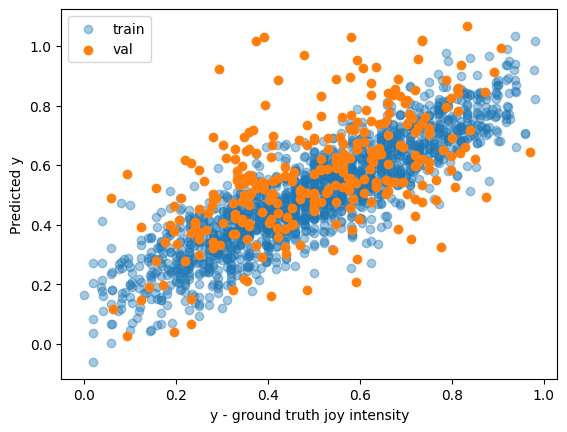

In [ ]:
# Use only the regularized model for the results below.
# Create a scatter plot of the actual vs. predicted values of `y` using this function.
def plot(y_train, y_hat_train, y_val, y_hat_val):
    fig, ax = plt.subplots(1)
    ax.scatter(y_train, y_hat_train, alpha=0.4, label='train')
    ax.scatter(y_val, y_hat_val, label='val')
    ax.set_xlabel('y - ground truth joy intensity')
    ax.set_ylabel('Predicted y')
    ax.legend()


# TODO [1 point] show y_hat versus y on train and val data
# Should be no need to modify code, you get 1 point for getting
# something that looks correct.
with torch.no_grad():  # remember to turn off auto gradient tracking
    y_hat_train = model(X_train)
    y_hat_val = model(X_val)

plot(y_train, y_hat_train, y_val, y_hat_val)

In [ ]:
# TODO [1 point] Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
happy = "I am really happy and excited for Monday. Yay!"
sad = "I am scared to walk alone at night in DTLA."


happy_embed = embed_sentence(AutoModel.from_pretrained("bert-base-uncased"), tokenizer, happy).squeeze(0)
sad_embed = embed_sentence(AutoModel.from_pretrained("bert-base-uncased"), tokenizer, sad).squeeze(0)

y_hat_happy = model(happy_embed).item()
y_hat_sad = model(sad_embed).item()

# Print results
print('{:0.2f} - {}'.format(y_hat_happy, happy))
print('{:0.2f} - {}'.format(y_hat_sad, sad))


0.68 - I am really happy and excited for Monday. Yay!
0.15 - I am scared to walk alone at night in DTLA.


### Exporting the Notebook to PDF
To generate a nice looking PDF of your completed notebook, either use "Print" as PDF from Google colab (using Chrome), or if you are running locally, run the following command in the last cell:
```python
!jupyter nbconvert --to pdf --output=yourname_submission.pdf hw1.ipynb
```

## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point.
- Compare multiple embedding methods. For instance, I'd look at a contrastive method like
princeton-nlp/unsup-simcse-bert-base-uncased or sentence-transformers/all-mpnet-base-v2 and a CLIP variant (trained on text and images). I hypothesize the contrastive methods will be better than CLIP for this task (which is not a visual task). You could also try a GPT model embedding, but while they are great at generation the embeddings are typically not useful for other tasks.
- Work ahead and try putting in a multi-layer MLP and training with SGD. How much can you improve the validation loss?
- Compare different strategies for extracting BERT embeddings: instead of using the mean embedding like I showed in class, compare to the embedding from the first token (to make this work better, people sometimes prepend the sentence with a special [cls] token before tokenizing).